# Imports

In [ ]:
import numpy as np
from numpy.linalg import *
import matplotlib.pyplot as plt; from matplotlib import cm
import time
import sys

# Main class

In [6]:
%matplotlib notebook  

class LBM:
    def __init__(self, re, nx, ny, is_plot = False, periodic_bcs = True, cx = 0, cy = 0, r = 0):
        """
        re (float)   : Reynolds number 
        nx (integer) : Resolution in x axis
        ny (integer) : Resolution in y axis 
        is_plot (boolean) : If True, results are ploted in realtime
        periodic_bcs (boolean) : If True, top and bottom walls are periodic boundary conditions
        cx (integer) : Position of the cylinder's center 
        cy (integer) : Position of the cylinder's center
        r (integer)  : Cylinder's radius
        """
        
        self.periodic_bcs = periodic_bcs
        self.is_plot = is_plot
        self.re     = re  ; self.nx     = nx     ; self.ny     = ny        
        self.q = 9 ; self.uLB    = 0.04
        
        # Relaxation parameter
        self.nulb        = self.uLB*r/re
        self.omega = 1.0 / (3.*self.nulb+0.5)
        
        # Lattice velocities for D2Q9
        self.c = np.array([(x,y) for x in [0,-1,1] for y in [0,-1,1]])

        # Lattice weights for D2Q9
        self.weights = 1./36. * np.ones(self.q)                                   
        self.weights[np.asarray([norm(ci)<1.1 for ci in self.c])] = 1./9.; self.weights[0] = 4./9.
        
        # Lattice directions for D2Q9
        self.noslip = [self.c.tolist().index((-self.c[i]).tolist()) for i in range(self.q)] 
        self.unknown_right  = np.arange(self.q)[np.asarray([ci[0]<0  for ci in self.c])] # Unknown on right wall.
        self.unknown_middle = np.arange(self.q)[np.asarray([ci[0]==0 for ci in self.c])] # Vertical middle.
        self.unknown_left   = np.arange(self.q)[np.asarray([ci[0]>0  for ci in self.c])] # Unknown on left wall.
        self.unknown_top    = np.arange(self.q)[np.asarray([ci[1]<0  for ci in self.c])] # Unknown on top wall.
        self.unknown_bottom = np.arange(self.q)[np.asarray([ci[1]>0  for ci in self.c])] # Unknown on bottom wall.
        
        # Obstacle matrix
        self.obstacle = np.fromfunction(lambda x,y: (x-cx)**2+(y-cy)**2<r**2, (nx,ny))
            
        # LBM variables
        self.feq = np.zeros((self.q,self.nx,self.ny))
        self.rho = np.ones((self.nx,self.ny))
        self.u_inlet = np.fromfunction(lambda d,y: (1-d)*self.uLB,(2,ny))        
        self.u   = np.fromfunction(lambda d,x,y: (1-d)*self.uLB,(2,nx,ny))        
        self._equilibrium()
        self.fin = self.feq.copy()        
        self.fout = self.feq.copy()     
        
        # Create plot
        if(self.is_plot) :
            self.fig, self.ax = plt.subplots(1, dpi=100)
            self.x= np.linspace(0, self.nx, self.nx)
            self.y= np.linspace(0, self.ny, self.ny)
            
    def run(self, nb_iter):
        """
        nb_iter (integer)   : Number of iterations to compute
        """
            
        print('Starting loop...')
        starting_time = time.time()
        for iteration in range(nb_iter):
            sys.stdout.write('\r') ; sys.stdout.flush() ; sys.stdout.write('Iteration : %d'%iteration)            
            self._bcs()      
            self._compute_rho()
            self._compute_u() 
            self._inlet()
            self._equilibrium() 
            self._collision()  
            self._streaming()
            if(self.is_plot): self._post_treatment(iteration)
        
    def _sum_velocities(self, matrix):
        return np.sum(matrix,axis=0) 
    
    def _equilibrium(self):              # Equilibrium distribution function.
        cu   = 3.0 * np.dot(self.c, self.u.transpose(1,0,2))
        usqr = 3./2.*( self.u[0]**2 + self.u[1]**2 )        
        for i in range(self.q): self.feq[i,:,:] = self.rho * self.weights[i] * (1.+cu[i]+0.5*cu[i]**2-usqr)
    
    def _inlet(self):
        # Left wall: compute density from known populations.
        self.u[:,0,:] = self.u_inlet         
        self.rho[0,:] = 1./(1.-self.u[0,0,:]) * (self._sum_velocities(self.fin[self.unknown_middle,0,:])+2.*self._sum_velocities(self.fin[self.unknown_right,0,:]))
        self.fin[self.unknown_left,0,:] = self.fin[self.unknown_right,0,:] + self.feq[self.unknown_left,0,:] - self.fin[self.unknown_right,0,:]
    
    def _bcs(self):  
        # Top and bottom
        if(self.periodic_bcs):
            self.fin[self.unknown_top,:,-1]   = self.fin[self.unknown_bottom,:,-1] 
            self.fin[self.unknown_bottom,:,0] = self.fin[self.unknown_top,:,0]             
        # Right wall: outflow condition
        self.fin[self.unknown_right,-1,:] = self.fin[self.unknown_right,-2,:]             
                
    def _compute_rho(self):
        self.rho = self._sum_velocities(self.fin)
        
    def _compute_u(self):
        self.u = np.dot(self.c.transpose(), self.fin.transpose((1,0,2)))/self.rho
    
    def _collision(self):        
        self.fout = self.fin - self.omega * (self.fin - self.feq)
        # Bounce back for obstacles
        for i in range(self.q): self.fout[i,self.obstacle] = self.fin[self.noslip[i],self.obstacle]        
                
    def _streaming(self):
        # Fast way to compute the streaming step using np.roll
        for i in range(self.q):
            self.fin[i,:,:] = np.roll(np.roll(self.fout[i,:,:],self.c[i,0],axis=0),self.c[i,1],axis=1)        
    
    def _post_treatment(self, iteration):
        if (iteration%100==0): # Visualization
            self.ax.cla()
            self.ax.set_xlim((0, self.x[-1]))
            self.ax.set_ylim((0, self.y[-1]))
            self.ax.imshow(np.sqrt(self.u[0]**2+self.u[1]**2).transpose(),cmap=cm.coolwarm)
            self.fig.canvas.draw()
            self.fig.canvas.flush_events()   

# Run a simulation on a 300*150 grid for Re=70

<IPython.core.display.Javascript object>


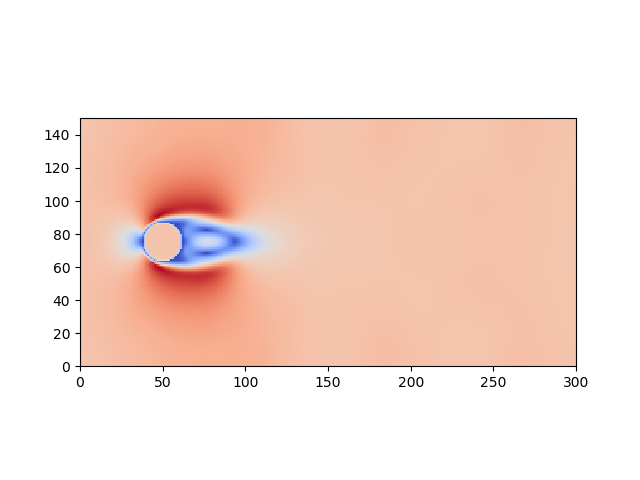

Starting loop...
Iteration : 1999

In [8]:
lbm = LBM(70, 300, 150, is_plot = True, cx=50, cy=75, r=12)
lbm.run(2000) # Run 2000 iterations